In [9]:
import os
import sys
import yaml
import torch
from gpytorch import kernels, distributions, constraints
import math
import numpy as np
import matplotlib.pyplot as plt
import tqdm

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import src.preprocessing as preproc
from src.models import *
from src.kernels import HaversineMaternKernel

## Load dataset and fitted model

In [10]:
# Load config file
with open('../config/svgp.yaml', "r") as f:
    cfg = yaml.safe_load(f)
cfg['dataset']['path'] = '../data/aodisaggregation_emmisions_test_6.3_ACCMIP_200806.06_echam.nc'

# Load dataset
data = preproc.make_data(cfg=cfg)
data.x_std[..., 2] = data.x[..., 2]
data.x_std[..., 3] = data.x[..., 3]
data.x_by_column_std[..., 2] = data.x[..., 2].reshape(data.x_by_column_std.size(0), data.x_by_column_std.size(1))
data.x_by_column_std[..., 3] = data.x[..., 3].reshape(data.x_by_column_std.size(0), data.x_by_column_std.size(1))

In [11]:
# Define kernel
time_kernel = kernels.ScaleKernel(kernels.MaternKernel(nu=1.5, ard_num_dims=1, active_dims=[0]))
latlon_kernel = HaversineMaternKernel(nu=1.5, active_dims=[2, 3], lengthscale_constraint=constraints.LessThan(math.pi / 2))
meteo_kernel = kernels.MaternKernel(nu=0.5, ard_num_dims=4, active_dims=[4, 5, 6, 7])
kernel = time_kernel * latlon_kernel + meteo_kernel

# Define aggregation operator
def trpz(grid):
    aggregated_grid = -torch.trapz(y=grid, x=data.h_by_column.unsqueeze(-1), dim=-2)
    return aggregated_grid

# Initialize inducing points regularly across grid
torch.random.manual_seed(cfg['model']['seed'])
lowaltitude_x_std = data.x_std[data.x_std[:, -1] < -cfg['model']['L']]
rdm_idx = torch.randperm(len(lowaltitude_x_std))[:cfg['model']['n_inducing_points']]
inducing_points = lowaltitude_x_std[rdm_idx]

# Initialize model
model = AggregateLogNormalSVGP(inducing_points=inducing_points,
                               transform=torch.exp,
                               kernel=kernel,
                               aggregate_fn=trpz)

# Load state dict
state_dict = torch.load('../sandbox/rebuttal/outputs/dev/svgp/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

### Infer $\varphi|\mathbf{\tau}$ over 50 calibration columns

In [12]:
# Choose a calibration columns to evaluate model over
torch.random.manual_seed(cfg['evaluation']['calibration_seed'])
calib_idx = torch.randperm(len(data.h_by_column_std))[:200]

# Initialize empty tensors
prediction_3d_means = torch.zeros_like(data.h_by_column_std[calib_idx])
prediction_3d_stddevs = torch.zeros_like(data.h_by_column_std[calib_idx])
h_stddev = data.h_by_column.std()

# Setup index iteration and progress bar
indices = torch.arange(len(data.x_by_column_std[calib_idx]))
n_samples = len(data.τ[calib_idx])
L = cfg['model']['L']
batch_size = cfg['evaluation']['batch_size']

with torch.no_grad():
    batch_iter = tqdm.notebook.tqdm(indices.split(batch_size))
    for idx in batch_iter:
        # Predict on standardized 3D covariates
        qf_by_column = model(data.x_by_column_std[idx])

        # Register in grid
        prediction_3d_means[idx] = qf_by_column.mean - data.h_by_column_std[idx] / L
        prediction_3d_stddevs[idx] = qf_by_column.stddev

    # Make up for height standardization in integration
    prediction_3d_means.sub_(torch.log(h_stddev))

    # Rescale predictions by τ/∫φdh
    def trpz(grid):
        aggregated_grid = -torch.trapz(y=grid, x=data.h_by_column[calib_idx].unsqueeze(-1).cpu(), dim=-2)
        return aggregated_grid
    φ = torch.exp(prediction_3d_means + 0.5 * prediction_3d_stddevs.square())
    aggregate_prediction_2d = trpz(φ.unsqueeze(-1)).squeeze()
    correction = torch.log(data.τ[calib_idx]) - torch.log(aggregate_prediction_2d)
    prediction_3d_means.add_(correction.unsqueeze(-1))
    
    # Make distribution
    prediction_3d_dist = torch.distributions.LogNormal(prediction_3d_means, prediction_3d_stddevs)

  0%|          | 0/4 [00:00<?, ?it/s]

### Compute ICI on a range of values for $\alpha_b$

In [13]:
# Sample from bext observation model
def sample_bext(prediction_3d_dist, sigma_ext, n_samples):
    φ = prediction_3d_dist.sample((n_samples,))
    eps = torch.finfo(torch.float64).eps
    loc = torch.log(φ.clip(min=eps)) - sigma_ext.square().div(2)
    bext = torch.distributions.LogNormal(loc, sigma_ext).sample().float()
    return bext

# Compute confidence region lower and upper bounds
def get_cr_bounds(bext, size):
    q_lb = (1 - float(size)) / 2
    q_ub = 1 - q_lb
    lb, ub = torch.quantile(bext, q=torch.tensor([q_lb, q_ub]), dim=0)
    return lb, ub

# Compute calibration plots for given region sizes
def compute_calibrations(prediction_3d_dist, sizes, sigma_ext, n_samples):
    calibration = []
    bext = sample_bext(prediction_3d_dist, sigma_ext, n_samples)
    for size in sizes:
        lb, ub = get_cr_bounds(bext, size)
        lb_mask = data.gt_by_column[calib_idx] > lb
        ub_mask = data.gt_by_column[calib_idx] < ub
        cr_mask = lb_mask & ub_mask
        calibration.append(cr_mask.float().mean().item())
    return np.asarray(calibration)

# Compute integral calibration index
def ICI(calibration, sizes):
    return np.abs(calibration - sizes).mean()

In [14]:
# Range of shapes for bext
sigma_exts = np.arange(0.01, 5, 0.01)
sigma_ext_iters = tqdm.notebook.tqdm(sigma_exts)

# Confidence region sizes to consider
sizes = np.arange(0.05, 1.0, 0.2)

# Number of samples to construct empirical confidence regions
n_samples = 256

integrals = []
for sigma_ext in sigma_ext_iters:
    sigma_ext = torch.tensor(sigma_ext)
    calibration = compute_calibrations(prediction_3d_dist, sizes, sigma_ext, n_samples)
    integrals.append(ICI(calibration, sizes))
integrals = np.asarray(integrals)

  0%|          | 0/499 [00:00<?, ?it/s]

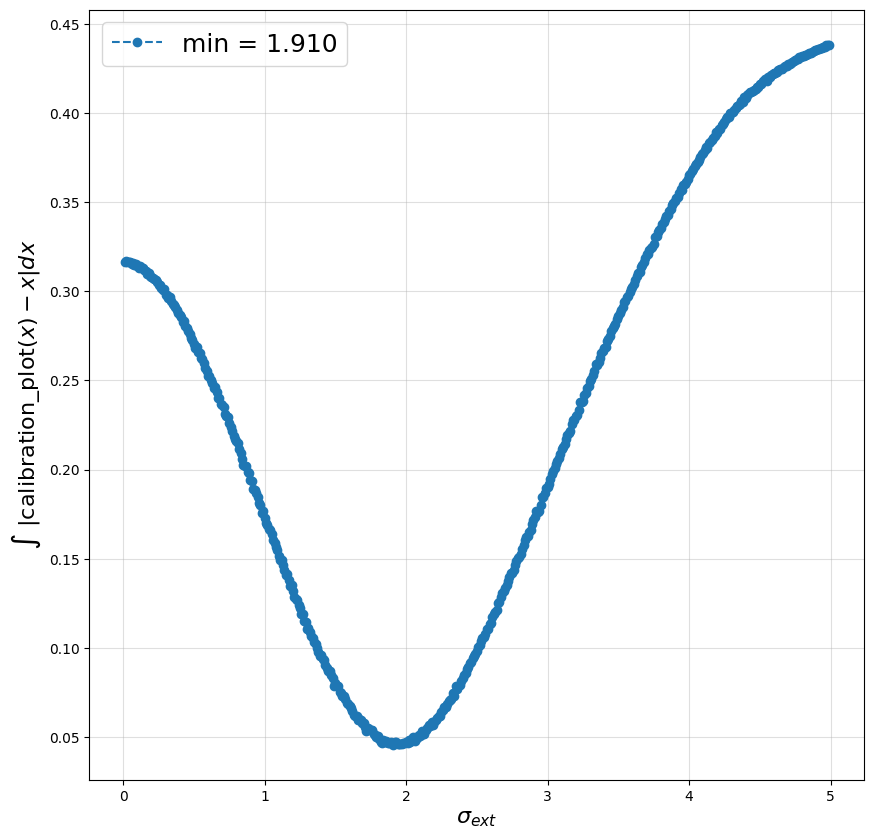

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

best_scale = sigma_exts[np.argmin(integrals)]
ax.plot(sigma_exts, integrals, '--o', label=f'min = {best_scale:.3f}')

ax.set_xlabel(r'$\sigma_{ext}$', fontsize=16)
ax.set_ylabel(r'$\int$ |calibration_plot$(x) - x|dx$ ', fontsize=16)
ax.grid(alpha=0.4)
plt.legend(fontsize=18)
plt.show()

## Plot calibration plot with chosen $\sigma_{ext}$

In [6]:
# Choose random columns different from calibration ones
torch.random.manual_seed(cfg['evaluation']['calibration_seed'])
rdm_idx = torch.randperm(len(data.h_by_column_std))[50:1050]

# Initialize empty tensors
prediction_3d_means = torch.zeros_like(data.h_by_column_std[rdm_idx])
prediction_3d_stddevs = torch.zeros_like(data.h_by_column_std[rdm_idx])
h_stddev = data.h_by_column.std()

# Setup index iteration and progress bar
indices = torch.arange(len(data.x_by_column_std[rdm_idx]))
n_samples = len(data.τ[calib_idx])
L = cfg['model']['L']
batch_size = cfg['evaluation']['batch_size']

with torch.no_grad():
    batch_iter = tqdm.notebook.tqdm(indices.split(batch_size))
    for idx in batch_iter:
        # Predict on standardized 3D covariates
        qf_by_column = model(data.x_by_column_std[idx])

        # Register in grid
        prediction_3d_means[idx] = qf_by_column.mean - data.h_by_column_std[idx] / L
        prediction_3d_stddevs[idx] = qf_by_column.stddev

    # Make up for height standardization in integration
    prediction_3d_means.sub_(torch.log(h_stddev))

    # Rescale predictions by τ/∫φdh
    def trpz(grid):
        aggregated_grid = -torch.trapz(y=grid, x=data.h_by_column[rdm_idx].unsqueeze(-1).cpu(), dim=-2)
        return aggregated_grid
    φ = torch.exp(prediction_3d_means + 0.5 * prediction_3d_stddevs.square())
    aggregate_prediction_2d = trpz(φ.unsqueeze(-1)).squeeze()
    correction = torch.log(data.τ[rdm_idx]) - torch.log(aggregate_prediction_2d)
    prediction_3d_means.add_(correction.unsqueeze(-1))
    
    # Make distribution
    prediction_3d_dist = torch.distributions.LogNormal(prediction_3d_means, prediction_3d_stddevs)

In [9]:
# Confidence region sizes to consider
sizes = np.arange(0.05, 1.0, 0.05)
sizes_iter = tqdm.notebook.tqdm(sizes)

# Number of samples to construct empirical confidence regions
n_samples = 256

# Set observation model shape parameter
sigma_ext = torch.tensor(2.120)

# Compute calibration scores for each confidence region size
calibration = []
bext = sample_bext(prediction_3d_dist, sigma_ext, n_samples)
for size in sizes_iter:
    lb, ub = get_cr_bounds(bext, size)
    lb_mask = data.gt_by_column[rdm_idx] > lb
    ub_mask = data.gt_by_column[rdm_idx] < ub
    cr_mask = lb_mask & ub_mask
    calibration.append(cr_mask.float().mean().item())

Text(0.5, 1.0, 'ABC123 vs $\\mathrm{ABC123}^{123}$')

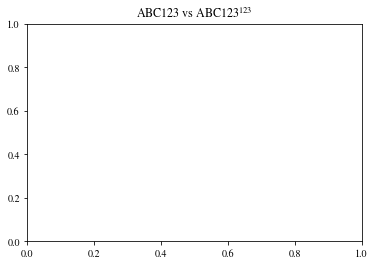

In [10]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

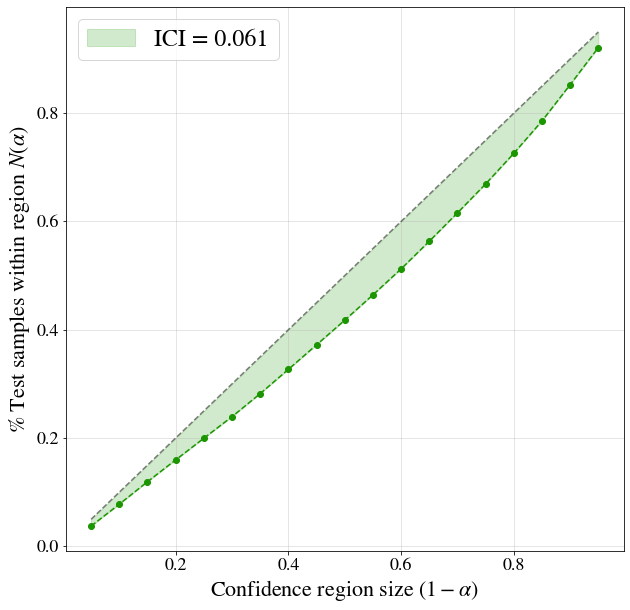

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

teal = '#1B9500'
ax.plot(sizes, sizes, 'k--', alpha=0.5)
ax.plot(sizes, calibration, '--o', color=teal)
ax.fill_between(sizes, calibration, sizes, alpha=0.2, color=teal, label=f'ICI = {ICI(calibration, sizes):.3f}')

ax.set_xlabel(r'Confidence region size $(1 - \alpha)$', fontsize=22)
ax.set_ylabel(r'% Test samples within region $N(\alpha)$', fontsize=22)
ax.tick_params(axis='both', labelsize=18)
ax.grid(alpha=0.4)

plt.legend(fontsize=24)